<a href="https://colab.research.google.com/github/map72ru/biz_learn/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево


In [20]:
from google.colab import drive
drive.mount('/content/hw2')

Drive already mounted at /content/hw2; to attempt to forcibly remount, call drive.mount("/content/hw2", force_remount=True).


In [21]:
import pandas as pd

Загружаем данные

In [22]:
data = pd.read_csv("hw2/MyDrive/data/data2.csv")
print(data.shape)
data.head(3)

(64000, 9)


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [23]:
data.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Rename target column
data = data.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
data = data.rename(columns={'offer': 'treatment'})

In [25]:
data.treatment.unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [41]:
data['dtreatment'] = data.treatment.map({'Buy One Get One': 1, 'No Offer': 0, 'Discount': 1})

In [27]:
data.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [28]:
data['dchannel'] = data.channel.map({'Phone': 1, 'Web': 2, 'Multichannel': 2})

In [29]:
data.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [30]:
data['dzip'] = data.zip_code.map({'Surburban': 1, 'Rural': 2, 'Urban': 3})

Выделим 4 типа покупателей:


1.   Покупателю не делали предложений, но он купил
2.   Покупателю делали предложения и он купил
3.   Покупателю делал предложения и он не купил
4.   Покупателю не дедали предложений и он не купил



In [33]:
data['customer_type'] = 0
data.loc[(data.dtreatment != 0) & (data.target == 1), 'customer_type'] = 1
data.loc[(data.dtreatment != 0) & (data.target == 0), 'customer_type'] = 2
data.loc[(data.dtreatment == 0) & (data.target == 0), 'customer_type'] = 3


In [34]:
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-ticks')
#plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 12})

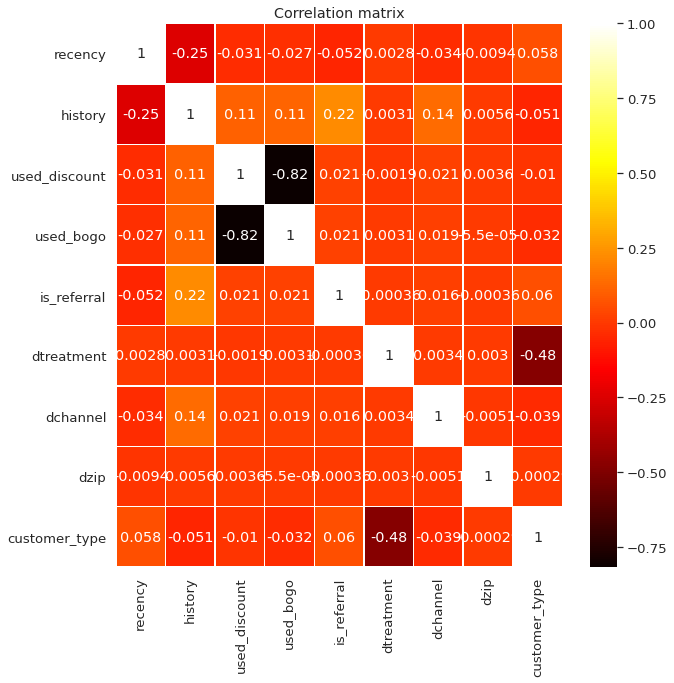

In [37]:
num_names = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'dtreatment', 'dchannel', 'dzip', 'customer_type']
plt.figure(figsize = (10,10))

sns.set(font_scale=1.2)
sns.heatmap(data[num_names].corr(), 
            annot=True, linewidths=.5, cmap='hot')

plt.title('Correlation matrix');

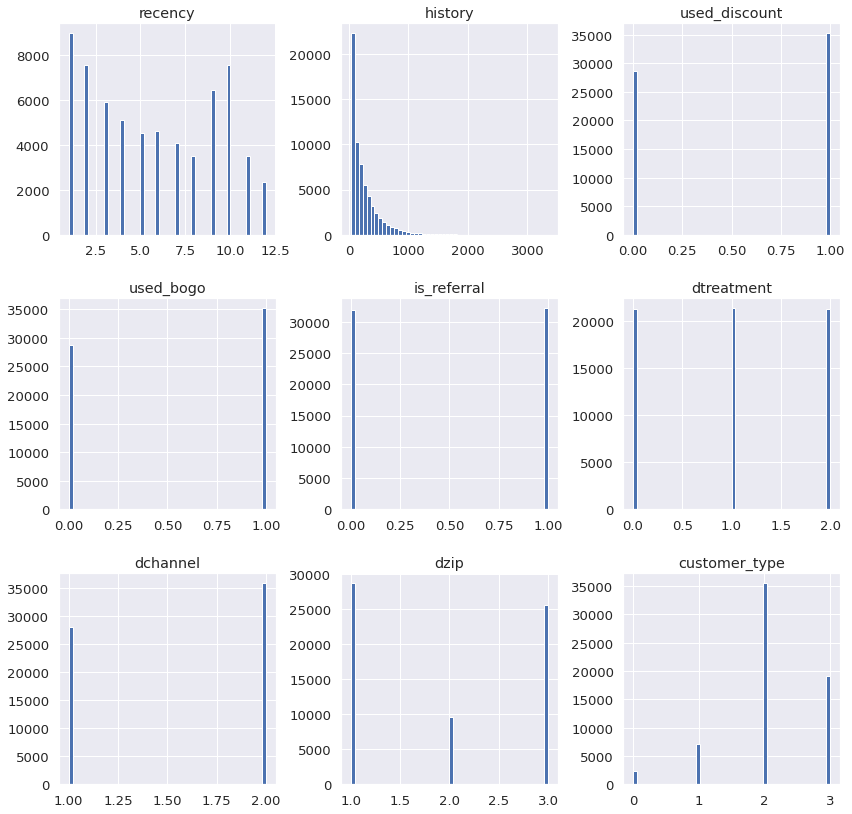

In [38]:
data[num_names].hist(figsize=(14,14), bins=50, grid=True);

In [51]:
from sklearn.model_selection import train_test_split
X = data[num_names]
y = data['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
treat_train = X_train.dtreatment

In [45]:
pip install scikit-uplift

In [47]:
pip install catboost

     |████████████████████████████████| 67.4 MB 29 kB/s 


In [53]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

In [54]:
uplift_sm = sm.predict(X_test)

In [56]:
result = {}

In [58]:
sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test.dtreatment, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score10:.4f}')

sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test.dtreatment, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score20:.4f}')

result.update({'SoloModel': {'10%': sm_score10, '20%': sm_score20}})



uplift@10%: 0.0037
uplift@20%: 0.3398


In [61]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test.dtreatment, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score10:.4f}')

sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test.dtreatment, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score20:.4f}')

result.update({'ClassTransform': {'10%': sm_score10, '20%': sm_score20}})

uplift@10%: 1.0000
uplift@20%: 0.8380


In [63]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test.dtreatment, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score10:.4f}')

sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test.dtreatment, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score20:.4f}')

result.update({'Tw0Models': {'10%': sm_score10, '20%': sm_score20}})

uplift@10%: 0.0093
uplift@20%: 0.3394


In [65]:
for key in result.keys():
  print(f"{key:15}: {result[key]['10%']:.4f} {result[key]['20%']:.4f}")

SoloModel      : 0.0037 0.3398
ClassTransform : 1.0000 0.8380
Tw0Models      : 0.0093 0.3394


In [68]:
pip install causalml

     |████████████████████████████████| 243 kB 12.9 MB/s 
     |████████████████████████████████| 326 kB 72.5 MB/s 
     |████████████████████████████████| 1.8 MB 75.6 MB/s 
     |████████████████████████████████| 678 kB 62.8 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496050 sha256=2ac043ee048e2f28784700fc6ff1275d8a5ca91673a3f2e6a466c3e6656907c2
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465073 sha256=725664683a34a88468fc4fbdbb4ccc0ebb774bec8aea2f77c383c3ef5f718046
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


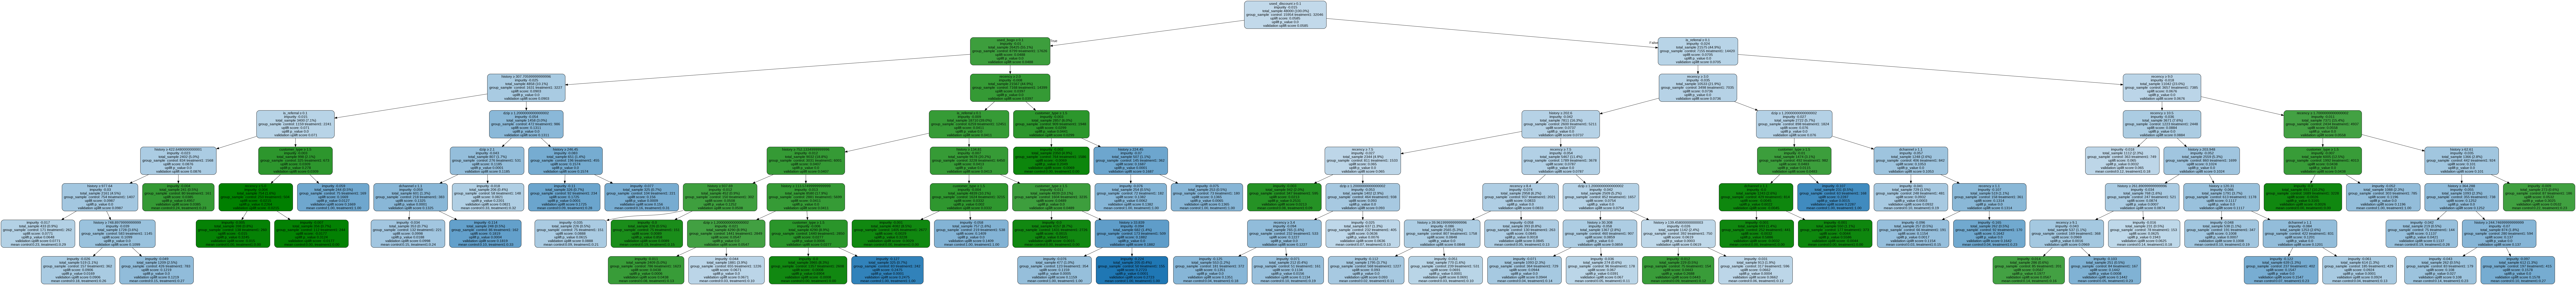

In [71]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, num_names)
Image(graph.create_png())

Если сопоставить матрице корреляций, то разбиение идет от самых значимых признаков к менее значимым.